✅ Appended 1170 real-time ERCOT rows.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 9.1994e-05 - val_loss: 2.3123e-04
Epoch 2/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.8394e-05 - val_loss: 2.2896e-04
Epoch 3/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.9571e-04 - val_loss: 2.0197e-04
Epoch 4/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.1410e-05 - val_loss: 1.7068e-04
Epoch 5/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.2371e-05 - val_loss: 1.7167e-04
Epoch 6/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 7.8226e-05 - val_loss: 1.6071e-04
Epoch 7/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.6557e-05 - val_loss: 1.6277e-04
Epoch 8/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 5.8566e-05 - val_loss: 1.5031e-04
Epoch 9/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.8302e-04 - val_loss: 1.4717e-04
Epoch 10/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.6374e-04 - val_loss: 1.5726e-04
Epoch 11/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 5.7708e-

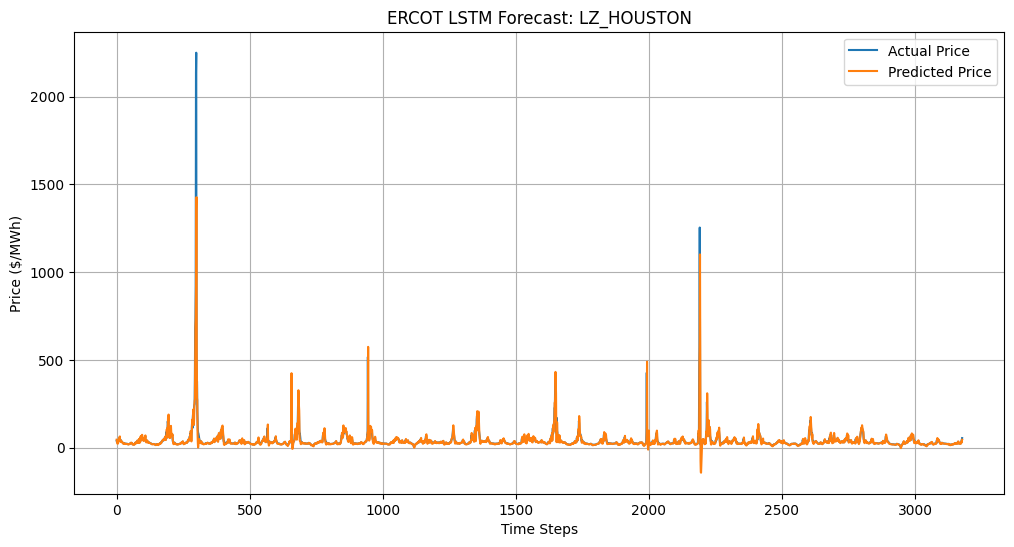


🔮 Latest predicted price for LZ_HOUSTON: $44.77

📊 Model Evaluation Metrics:
✅ RMSE: $43.25 per MWh
✅ MAPE: 15.78%
✅ R² Score (Model Confidence): 63.80%


In [75]:
# --- STEP 1: Install and Import Packages ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- STEP 2: Load Historical Excel Data ---
df = pd.read_excel("/2025Data.xlsx")

# Rename columns to standard format
df = df.rename(columns={
    "Delivery Date": "Date",
    "Delivery Hour": "Hour",
    "Delivery Interval": "Interval",
    "Settlement Point Name": "SettlementPoint",
    "Settlement Point Price": "Price"
})

# Construct timestamp from Delivery Date + Hour + Interval
df["Date"] = pd.to_datetime(df["Date"])
df["Hour"] = df["Hour"].astype(int) - 1
df["Interval"] = df["Interval"].astype(int)
df["Minute"] = (df["Interval"] - 1) * 15
df["Timestamp"] = df["Date"] + pd.to_timedelta(df["Hour"], unit='h') + pd.to_timedelta(df["Minute"], unit='m')

# Create long-format historical table
df_long = df[["Timestamp", "SettlementPoint", "Price"]]

# --- STEP 3: Append Real-Time ERCOT Data (with safe timestamp parsing) ---
try:
    url = "https://www.ercot.com/content/cdr/html/real_time_spp.html"
    df_live = pd.read_html(url)[0]
    df_live.columns = df_live.columns.str.strip()

    date_col = pd.to_datetime(df_live.iloc[:, 0], format="%m/%d/%Y")
    time_col = df_live.iloc[:, 1].astype(str).str.zfill(4)

    df_live["Timestamp"] = pd.to_datetime(
        date_col.dt.strftime("%Y-%m-%d") + " " +
        time_col.str[:2] + ":" + time_col.str[2:], format="%Y-%m-%d %H:%M"
    )

    df_live = df_live.drop(df_live.columns[[0, 1]], axis=1)

    df_live_long = df_live.melt(id_vars=["Timestamp"], var_name="SettlementPoint", value_name="Price")
    df_live_long.dropna(subset=["Price"], inplace=True)

    df_long = pd.concat([df_long, df_live_long], ignore_index=True).drop_duplicates(subset=["Timestamp", "SettlementPoint"])
    print(f"✅ Appended {len(df_live_long)} real-time ERCOT rows.")
except Exception as e:
    print("⚠️ Real-time ERCOT data not appended:", e)

# --- STEP 4: Filter by Settlement Point (e.g., LZ_HOUSTON) ---
node_id = "LZ_HOUSTON"
df_node = df_long[df_long["SettlementPoint"] == node_id].sort_values("Timestamp").reset_index(drop=True)

# --- STEP 5: Normalize the Price Data ---
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df_node[["Price"]])

# --- STEP 6: Create Sequences for LSTM ---
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

SEQ_LENGTH = 24
x, y = create_sequences(scaled_prices, SEQ_LENGTH)

# --- STEP 7: Train/Test Split ---
split_index = int(0.8 * len(x))
x_train, y_train = x[:split_index], y[:split_index]
x_test, y_test = x[split_index:], y[split_index:]

# --- STEP 8: Build and Train LSTM Model ---
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, epochs=50, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[early_stop], verbose=1)

# --- STEP 9: Make Predictions and Inverse Transform ---
predicted = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

# --- STEP 10: Plot Results ---
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'ERCOT LSTM Forecast: {node_id}')
plt.xlabel("Time Steps")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.grid(True)
plt.show()

# --- STEP 11: Print Latest Forecast ---
latest_predicted_price = predicted_prices[-1][0]
print(f"\n🔮 Latest predicted price for {node_id}: ${latest_predicted_price:.2f}")

# --- STEP 12: Evaluate Model Performance ---
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print("\n📊 Model Evaluation Metrics:")
print(f"✅ RMSE: ${rmse:.2f} per MWh")
print(f"✅ MAPE: {mape * 100:.2f}%")
print(f"✅ R² Score (Model Confidence): {r2:.2%}")


In [80]:
import pandas as pd

url = 'http://www.ercot.com/content/cdr/html/real_time_spp.html'
df = pd.read_html(url)[0]

zone = 'LZ_HOUSTON'
latest_price = df[zone].iloc[-1]
print(f"✅ Latest ERCOT price for {zone}: ${latest_price:.2f}")

✅ Latest ERCOT price for LZ_HOUSTON: $54.12
